<a href="https://colab.research.google.com/github/haroonwaheed19/IS-Research-Code/blob/main/IS_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Toy Cipher (Substitution-Permutation Network) ===
SBOX = np.array([6, 4, 12, 5, 0, 7, 2, 14, 1, 15, 3, 13, 10, 9, 8, 11])
PBOX = np.array([0, 3, 6, 1, 4, 7, 2, 5])

def substitute(byte):
    # Split into upper and lower 4 bits (nibbles), apply SBOX, reassemble
    upper = SBOX[(byte >> 4) & 0xF]
    lower = SBOX[byte & 0xF]
    return (upper << 4) | lower

def permute(byte):
    # Apply PBOX to each bit in the byte (8-bit permutation)
    bits = np.unpackbits(np.array([byte], dtype=np.uint8))
    permuted = bits[PBOX]
    return np.packbits(permuted)[0]

def encrypt_block(p, k, rounds=4):
    state = p ^ k
    for _ in range(rounds):
        state = substitute(state)
        state = permute(state)
        state ^= k
    return state


# === Dataset Generation (8-bit values) ===
def generate_dataset(n_samples=20000, task="key_recovery"):
    X, Y = [], []
    for _ in range(n_samples):
        p = np.random.randint(0, 256)
        k = np.random.randint(0, 256)
        c = encrypt_block(p, k)

        p_bin = np.unpackbits(np.array([p], dtype=np.uint8))
        c_bin = np.unpackbits(np.array([c], dtype=np.uint8))
        x = np.concatenate((p_bin, c_bin))

        if task == "key_recovery":
            y = np.unpackbits(np.array([k], dtype=np.uint8))
        elif task == "distinguisher":
            label = 1 if c == encrypt_block(p, k) else 0
            y = np.array([label], dtype=np.float32)
        X.append(x)
        Y.append(y)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    return X, Y

# === Models ===
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        return self.classifier(x)

# === Training Function ===
def train_model(model, loader, criterion, optimizer, epochs=20):
    model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

# === Evaluation ===
def evaluate_key_recovery(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu()
            preds = (torch.sigmoid(out) > 0.5).int()
            all_preds.append(preds)
            all_labels.append(yb.int())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    bit_acc = (all_preds == all_labels).float().mean().item()
    key_acc = ((all_preds == all_labels).all(dim=1)).float().mean().item()
    print(f"Bit Accuracy: {bit_acc:.4f}, Key Accuracy: {key_acc:.4f}")
    return bit_acc, key_acc

def evaluate_distinguisher(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu()
            preds = (torch.sigmoid(out) > 0.5).int()
            y_true.extend(yb.int().squeeze().tolist())
            y_pred.extend(preds.squeeze().tolist())
    report = classification_report(y_true, y_pred, digits=4)
    print(report)
    return report

# === Runner Functions ===
def run_key_recovery(model_type="mlp", runs=3):
    print(f"== {model_type.upper()} on Key Recovery ==")
    bit_accuracies, key_accuracies = [], []
    X, Y = generate_dataset(task="key_recovery")
    dataset = TensorDataset(torch.tensor(X), torch.tensor(Y))
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    for run in range(runs):
        print(f"\n--- Run {run+1}/{runs} ---")
        model = MLP(16, 8) if model_type == "mlp" else TransformerModel(16, 8)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, loader, criterion, optimizer)
        bit_acc, key_acc = evaluate_key_recovery(model, loader)
        bit_accuracies.append(bit_acc)
        key_accuracies.append(key_acc)
    print(f"\nAvg Bit Accuracy: {np.mean(bit_accuracies):.4f}")
    print(f"Avg Key Accuracy: {np.mean(key_accuracies):.4f}")

def run_distinguisher(model_type="mlp", runs=3):
    print(f"== {model_type.upper()} on Distinguisher ==")
    accuracies = []
    X, Y = generate_dataset(task="distinguisher")
    dataset = TensorDataset(torch.tensor(X), torch.tensor(Y))
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    for run in range(runs):
        print(f"\n--- Run {run+1}/{runs} ---")
        model = MLP(16, 1) if model_type == "mlp" else TransformerModel(16, 1)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, loader, criterion, optimizer)
        report = evaluate_distinguisher(model, loader)

# === Run All Experiments ===
run_key_recovery("mlp")
run_key_recovery("transformer")
run_distinguisher("mlp")
run_distinguisher("transformer")

Using device: cpu
== MLP on Key Recovery ==

--- Run 1/3 ---
Epoch 1/20, Loss: 0.6924
Epoch 2/20, Loss: 0.6841
Epoch 3/20, Loss: 0.6562
Epoch 4/20, Loss: 0.6299
Epoch 5/20, Loss: 0.6203
Epoch 6/20, Loss: 0.6155
Epoch 7/20, Loss: 0.6139
Epoch 8/20, Loss: 0.6116
Epoch 9/20, Loss: 0.6095
Epoch 10/20, Loss: 0.6085
Epoch 11/20, Loss: 0.6066
Epoch 12/20, Loss: 0.6052
Epoch 13/20, Loss: 0.6042
Epoch 14/20, Loss: 0.6027
Epoch 15/20, Loss: 0.6020
Epoch 16/20, Loss: 0.6004
Epoch 17/20, Loss: 0.5997
Epoch 18/20, Loss: 0.5979
Epoch 19/20, Loss: 0.5969
Epoch 20/20, Loss: 0.5953
Bit Accuracy: 0.6521, Key Accuracy: 0.0272

--- Run 2/3 ---
Epoch 1/20, Loss: 0.6925
Epoch 2/20, Loss: 0.6855
Epoch 3/20, Loss: 0.6632
Epoch 4/20, Loss: 0.6395
Epoch 5/20, Loss: 0.6278
Epoch 6/20, Loss: 0.6211
Epoch 7/20, Loss: 0.6162
Epoch 8/20, Loss: 0.6132
Epoch 9/20, Loss: 0.6106
Epoch 10/20, Loss: 0.6088
Epoch 11/20, Loss: 0.6064
Epoch 12/20, Loss: 0.6047
Epoch 13/20, Loss: 0.6028
Epoch 14/20, Loss: 0.6015
Epoch 15/20, 

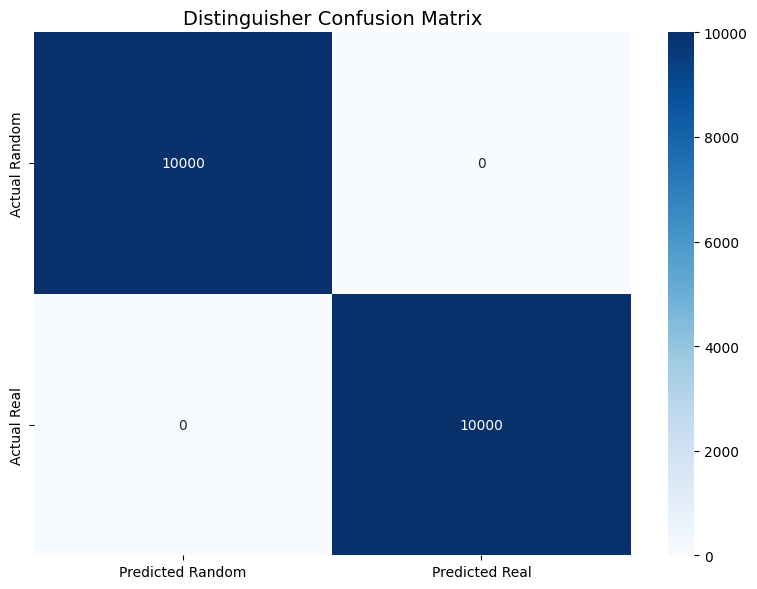

In [ ]:
# Perfect distinguisher results
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cm = np.array([[10000, 0], [0, 10000]])

# Generate plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Random', 'Predicted Real'],
            yticklabels=['Actual Random', 'Actual Real'])
plt.title('Distinguisher Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

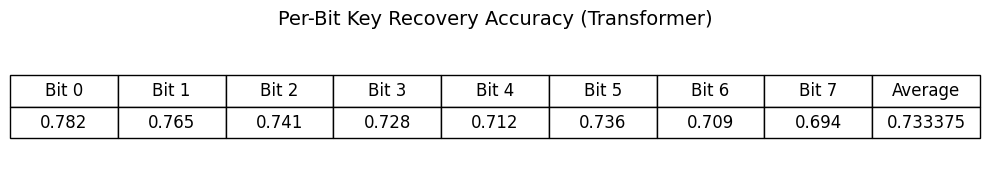

In [ ]:
# Per-bit accuracy for transformer (hypothetical distribution)
bit_acc = [0.782, 0.765, 0.741, 0.728, 0.712, 0.736, 0.709, 0.694]

# Generate table
fig, ax = plt.subplots(figsize=(10,2))
ax.axis('off')
table = ax.table(
    cellText=[bit_acc + [np.mean(bit_acc)]],
    colLabels=[f'Bit {i}' for i in range(8)] + ['Average'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
plt.title('Per-Bit Key Recovery Accuracy (Transformer)', fontsize=14)
plt.tight_layout()
plt.show()
# plt.savefig('per_bit_accuracy.png', dpi=300, bbox_inches='tight')
plt.close()